In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import plotly.express as px
import seaborn as sns

from tqdm import tqdm
from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab')
nltk.download('stopwords')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
train_clean_df = pd.read_csv('/home/workspace/data/GLDv2/train/train_clean_custom.csv')

In [2]:
train_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342470 entries, 0 to 1342469
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1342470 non-null  object
 1   landmark_id  1342470 non-null  int64 
 2   description  1342470 non-null  object
 3   language     1342470 non-null  object
dtypes: int64(1), object(3)
memory usage: 41.0+ MB


In [3]:
train_clean_df.head()

,id,landmark_id,description,language
0,17660ef415d37059,1,Luitpoldpark is a public park in the Schwabing...,en
1,92b6290d571448f6,1,Luitpoldpark is a public park in the Schwabing...,en
2,cd41bf948edc0340,1,Luitpoldpark is a public park in the Schwabing...,en
3,fb09f1e98c6d2f70,1,Luitpoldpark is a public park in the Schwabing...,en
4,25c9dfc7ea69838d,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de


### 언어 분포

In [4]:
train_clean_df['language'].value_counts()

language
en    1096962
de     169827
fr      72685
ko       2996
Name: count, dtype: int64

- landmark 종류는 63,428개, 이미지 전체 개수는 1,342,470개
- 6,000개 이미지를 가진 랜드마크가 존재함(landmark id: 138982)
- 그 다음엔 2,000개 이미지를 가진 랜드마크가 존재함(landmark id: 62798)
- 61,583개의 랜드마크가 100개 이하 이미지를 가지고 있음(97.1%)

In [8]:
# displaying only top 30 landmark
landmark = train_clean_df.landmark_id.value_counts()
landmark_df = pd.DataFrame({'landmark_id':landmark.index, 'frequency':landmark.values}).head(30)

landmark_df['landmark_id'] = landmark_df.landmark_id.apply(lambda x: f'landmark_id_{x}')

fig = px.bar(landmark_df, x="frequency", y="landmark_id",color='landmark_id', orientation='h',
             hover_data=["landmark_id", "frequency"],
             height=1000,
             title='Number of images per landmark_id (Top 30 landmark_ids)')
fig.show()

In [10]:
landmark_df = landmark.to_frame(name='frequency')
landmark_df[landmark_df['frequency'] <= 100]

,frequency
landmark_id,
59833,100
63593,100
28989,100
3046,100
89587,100
...,...
101612,2
145164,2
22873,2


### 텍스트 길이

In [22]:
str_len_mean = np.mean(train_clean_df['description'].str.len()) # description 길이의 평균값 계산
str_len_min = np.min(train_clean_df['description'].str.len()) # description 길이의 최소값 계산
str_len_max = np.max(train_clean_df['description'].str.len()) # description 길이의 최대값 계산
print('description의 평균 길이 :', round(str_len_mean,0))
print('description의 최소 길이 :', str_len_min)
print('description의 최대 길이 :', str_len_max)

description의 평균 길이 : 685.0
description의 최소 길이 : 19
description의 최대 길이 : 9147


- description의 평균 텍스트 길이: 685
- description의 최소 텍스트 길이: 19
- description의 최대 텍스트 길이: 9147

In [23]:
train_clean_df['length'] = train_clean_df['description'].str.len()

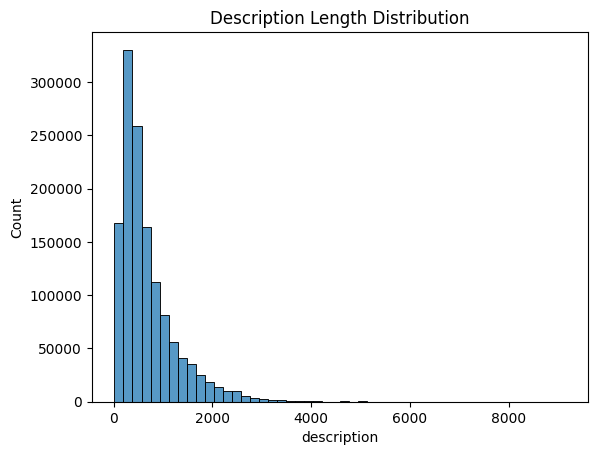

In [17]:
# 히스토그램
fig, ax = plt.subplots()
sns.histplot(train_clean_df['description'].str.len(), bins=50, ax=ax)
ax.set_title("Description Length Distribution")
plt.show()

### 단어 개수

In [24]:
def word_count(description):
    description_list = description.split()
    return len(description_list)

In [25]:
train_clean_df['Word_count'] = train_clean_df['description'].apply(word_count)
train_clean_df.head(10)

,id,landmark_id,description,language,length,Word_count
0,17660ef415d37059,1,Luitpoldpark is a public park in the Schwabing...,en,79,12
1,92b6290d571448f6,1,Luitpoldpark is a public park in the Schwabing...,en,79,12
2,cd41bf948edc0340,1,Luitpoldpark is a public park in the Schwabing...,en,79,12
3,fb09f1e98c6d2f70,1,Luitpoldpark is a public park in the Schwabing...,en,79,12
4,25c9dfc7ea69838d,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41
5,28b13f94a6f1f3c1,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41
6,307d6584f473ba35,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41
7,4a7ba9eb16d51bc4,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41
8,597353dfbb3df649,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41
9,a40d00dc4fcc3a10,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41


### 한 문단의 모든 단어 길이의 평균

In [26]:
train_clean_df['mean_word_length'] = train_clean_df['description'].map(lambda desc: np.mean([len(word) for word in desc.split()]))
train_clean_df.head(10)

,id,landmark_id,description,language,length,Word_count,mean_word_length
0,17660ef415d37059,1,Luitpoldpark is a public park in the Schwabing...,en,79,12,5.666667
1,92b6290d571448f6,1,Luitpoldpark is a public park in the Schwabing...,en,79,12,5.666667
2,cd41bf948edc0340,1,Luitpoldpark is a public park in the Schwabing...,en,79,12,5.666667
3,fb09f1e98c6d2f70,1,Luitpoldpark is a public park in the Schwabing...,en,79,12,5.666667
4,25c9dfc7ea69838d,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41,7.341463
5,28b13f94a6f1f3c1,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41,7.341463
6,307d6584f473ba35,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41,7.341463
7,4a7ba9eb16d51bc4,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41,7.341463
8,597353dfbb3df649,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41,7.341463
9,a40d00dc4fcc3a10,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41,7.341463


### 문장 길이의 평균

In [37]:
np.mean([len(sent) for sent in tokenize.sent_tokenize(train_clean_df['description'][0])])


79.0

In [38]:
train_clean_df['mean_sent_length'] = train_clean_df['description'].map(lambda desc: np.mean([len(sent) for sent in tokenize.sent_tokenize(desc)]))
train_clean_df.head(10)

,id,landmark_id,description,language,length,Word_count,mean_word_length,mean_sent_length
0,17660ef415d37059,1,Luitpoldpark is a public park in the Schwabing...,en,79,12,5.666667,79.0
1,92b6290d571448f6,1,Luitpoldpark is a public park in the Schwabing...,en,79,12,5.666667,79.0
2,cd41bf948edc0340,1,Luitpoldpark is a public park in the Schwabing...,en,79,12,5.666667,79.0
3,fb09f1e98c6d2f70,1,Luitpoldpark is a public park in the Schwabing...,en,79,12,5.666667,79.0
4,25c9dfc7ea69838d,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41,7.341463,113.0
5,28b13f94a6f1f3c1,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41,7.341463,113.0
6,307d6584f473ba35,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41,7.341463,113.0
7,4a7ba9eb16d51bc4,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41,7.341463,113.0
8,597353dfbb3df649,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41,7.341463,113.0
9,a40d00dc4fcc3a10,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de,341,41,7.341463,113.0


In [39]:
def visualize(col):
    
    print()
    plt.subplot(1,2,1)
    sns.boxplot(y=train_clean_df[col])
    plt.ylabel(col, labelpad=12.5)
    
    plt.subplot(1,2,2)
    sns.kdeplot(train_clean_df[col])
    plt.xlabel('')
    plt.ylabel('')
    
    plt.show()

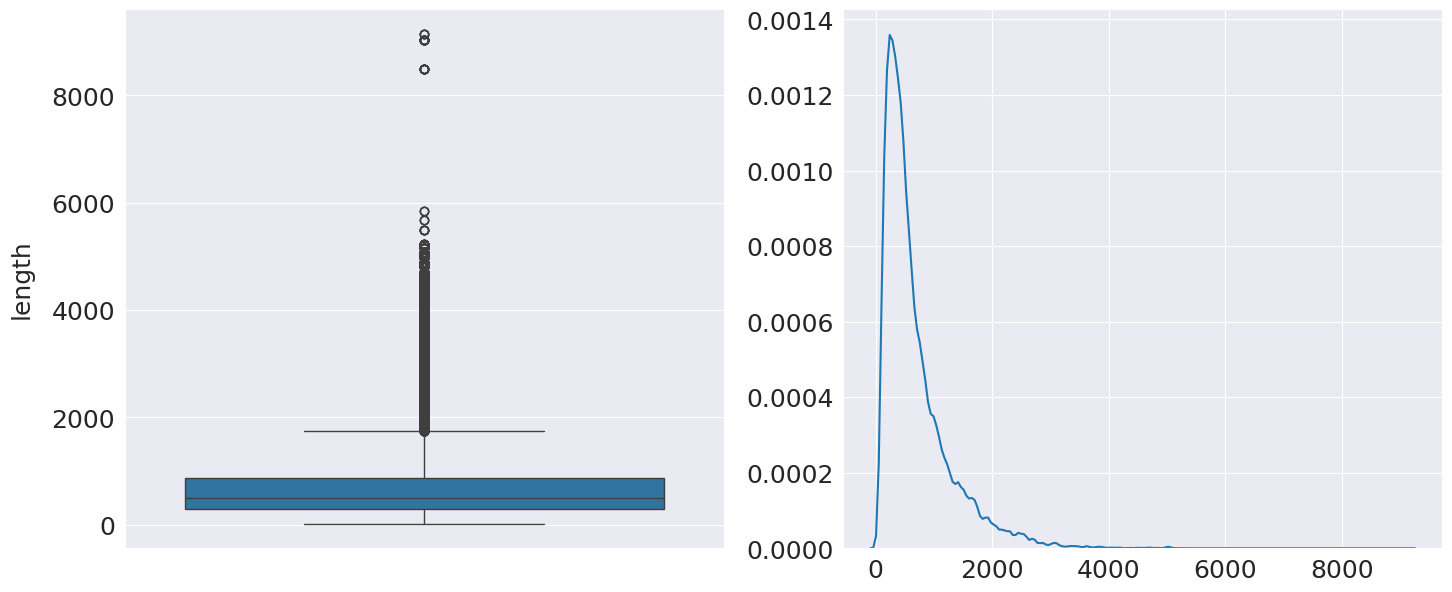

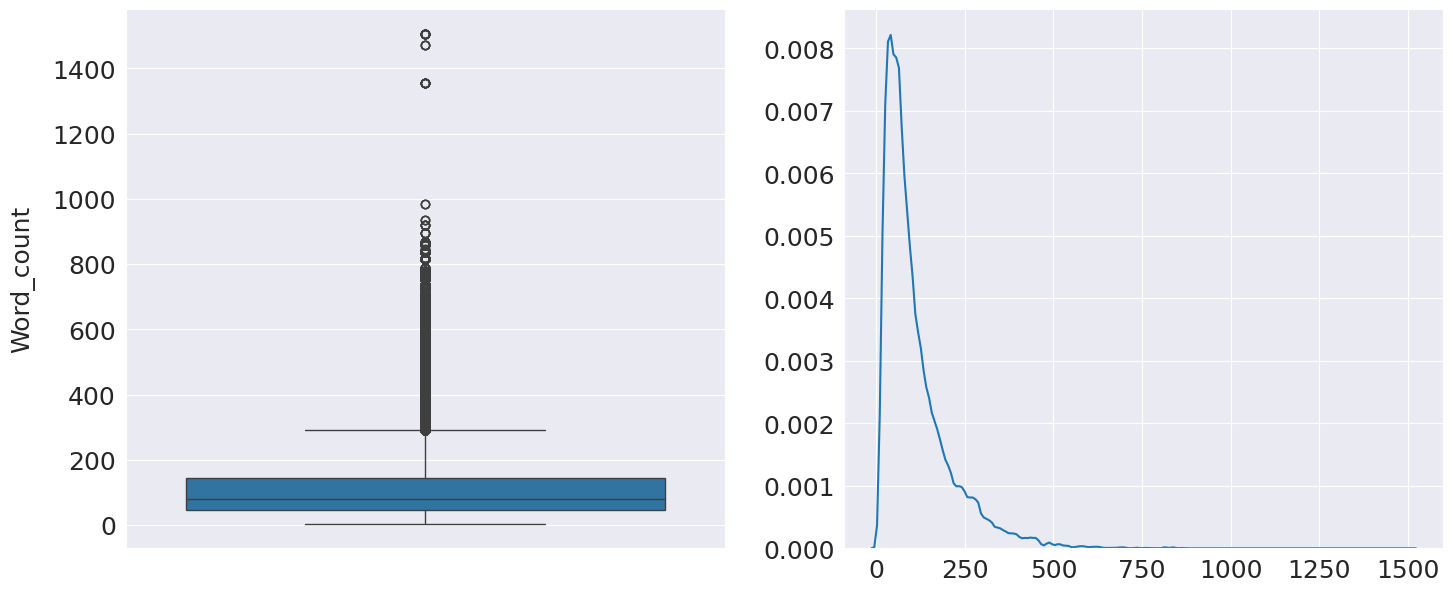

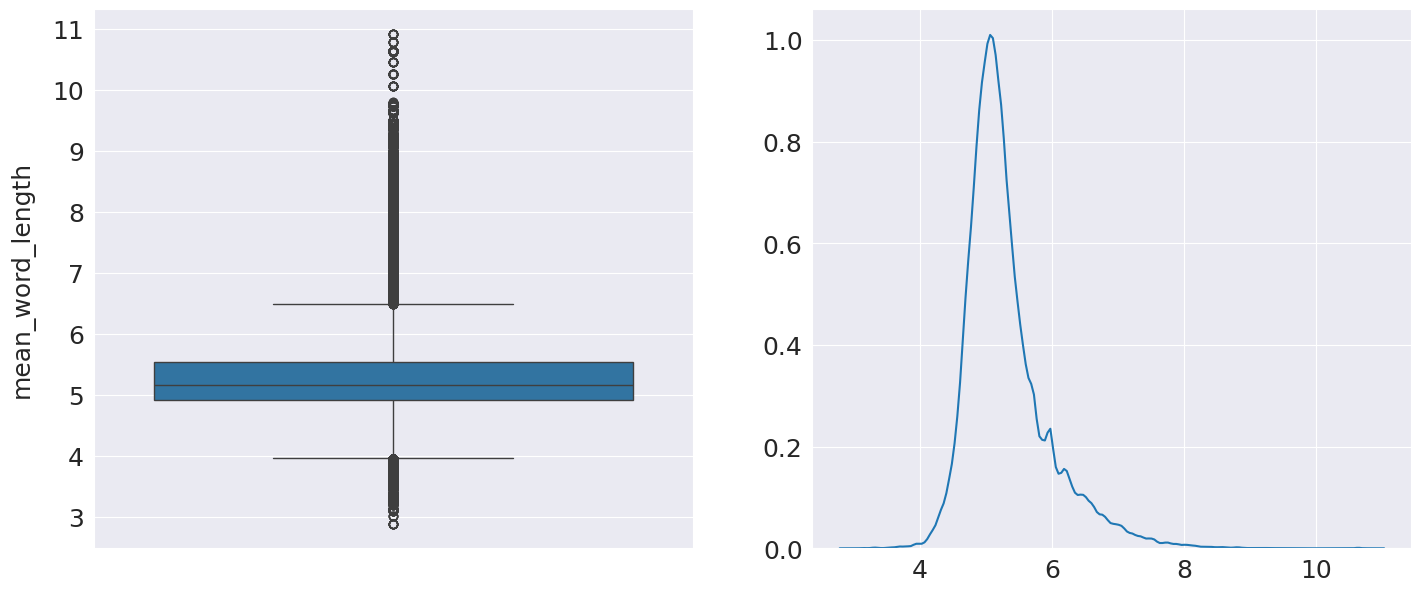

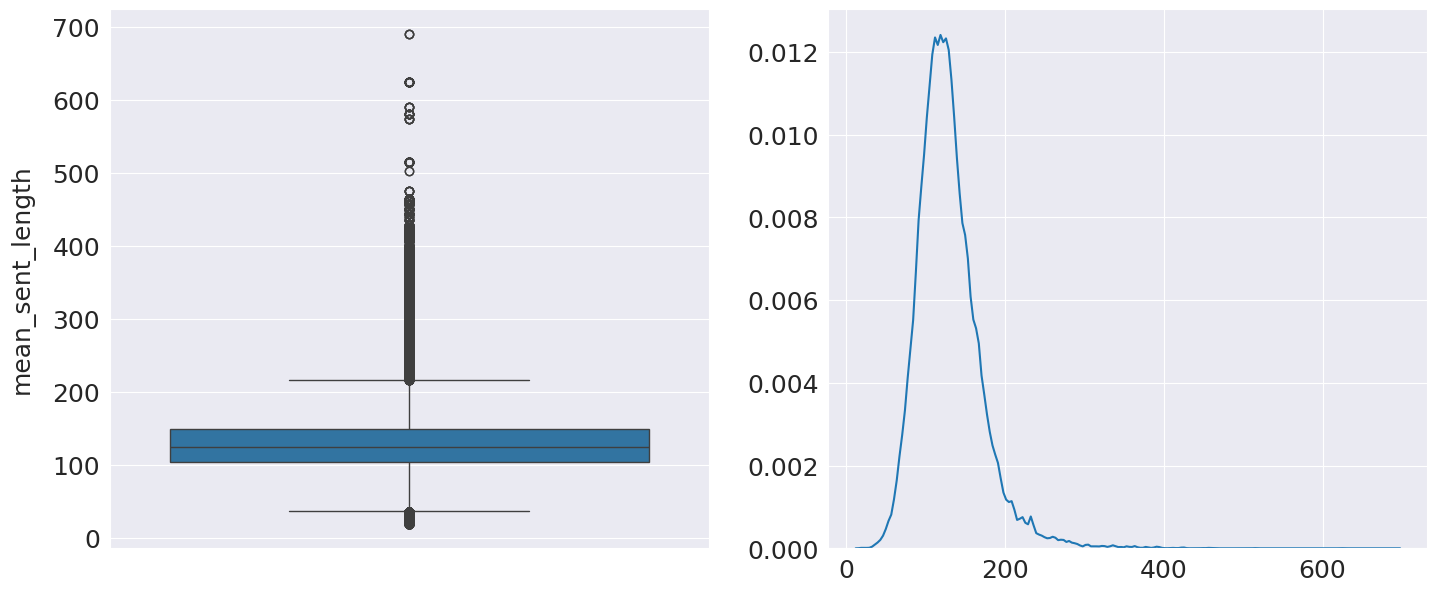

In [40]:
features = train_clean_df.columns.tolist()[-4:]  # 마지막 4개 열 선택
for feature in features:
    visualize(feature)

## Term Frequency Analysis
Examining the most frequently occuring words is one of the most popular systems of Text analytics. For example, in a sentiment analysis problem, a positive text is bound to have words like 'good', 'great', 'nice', etc. more in number than other words that imply otherwise.

Note: Term Frequencies are more than counts and lenghts, so the first requirement is to preprocess the text

In [41]:
df = train_clean_df.drop(features, axis=1)
df.head()

,id,landmark_id,description,language
0,17660ef415d37059,1,Luitpoldpark is a public park in the Schwabing...,en
1,92b6290d571448f6,1,Luitpoldpark is a public park in the Schwabing...,en
2,cd41bf948edc0340,1,Luitpoldpark is a public park in the Schwabing...,en
3,fb09f1e98c6d2f70,1,Luitpoldpark is a public park in the Schwabing...,en
4,25c9dfc7ea69838d,7,Die Sparkassen-Arena ist eine Mehrzweckhalle i...,de


There is no missing data, therefore, we can move to the next stage. For Term frequency analysis, it is essential that the text data be preprocessed.

- Lowercase
- Remove punctutations
- Stopword removal

In [42]:
def clean(review):
    
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    
    return review

In [ ]:
df['description'][0]

'Luitpoldpark is a public park in the Schwabing-West borough of Munich, Germany.'

In [60]:
df['description'] = df['description'].progress_apply(clean)

100%|██████████| 1342470/1342470 [3:05:08<00:00, 120.85it/s] 


In [61]:
df['description'][0]

'luitpoldpark public park schwabing-west borough munich germany'

In [6]:
df = pd.read_csv('/home/workspace/data/GLDv2/train/train_clean_eda.csv')

In [14]:
df.dropna(inplace=True)

In [9]:
def corpus(text):
    text_list = text.split()
    return text_list

In [16]:
df['description_lists'] = df['description'].apply(corpus)

In [27]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['description_lists'].iloc[i]
len(corpus)

  0%|                                                                                                                     | 0/1341845 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1341845/1341845 [00:10<00:00, 126758.36it/s]


93111434

In [28]:
mostCommon = Counter(corpus).most_common(10)

[('de', 617152),
 ('church', 592756),
 ('der', 557435),
 ('located', 533226),
 ('city', 422414),
 ('built', 388081),
 ('one', 379229),
 ('also', 366067),
 ('park', 344327),
 ('building', 341592)]

In [30]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

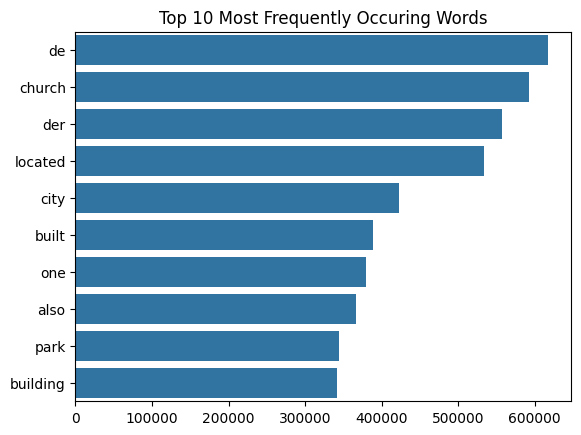

In [31]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()